# Deep Learning haciendo uso de CNN: ResNet
---
### Trabajo Final del curso Machine Learning
### Docente: M.Sc. Richard Fernández 

**Integrantes**:
- Lucas Parodi Roman
- Eduardo Contreras
- Dante Moreno




## 1. Introducción

Deep Learning es un subcampo de Machine Learning, enfocado en algoritmos inspirados por la estructura y funcionalidad de las redes neuronales artificiales $^{[1]}$. El número de capas en una red neuronal es conocido como la profundidad de la red; y Deep Learning aprovecha la capacidad del hardware actual para utilizar redes neuronales más profundas que antes. En las últimas décadas, Deep Learning ha demostrado gran potencial gracias a su habilidad de manejar grandes volúmenes de data. $^{[2]}$

El propósito de este trabajo es estudiar y aplicar Deep Learning utilizando redes convolucionales. Para esto, implementamos redes residuales, conocidas también como ResNet, en un caso de estudio. Luego, analizamos los resultados obtenidos para extraer conclusiones y recomendaciones pertinentes al caso de estudio.

## 2. Marco Teórico

### 2.1. Redes Neuronales Convolucionales

En 2012, la visión computacional presenció un gran avance cuando un grupo de investigadores de la Universidad de Toronto desarrolló AlexNet, un sistema que se basaba en redes convolucionales artificiales, o CNN por sus siglas en inglés. $^{[2]}$ Este modelo superó a los mejores algoritmos de reconocimiento de imágenes por un amplio margen. Estas redes usan una técnica especial llamada Convolución, con la que reducen las imágenes a una forma que es más fácil de procesar.

<img src='https://editor.analyticsvidhya.com/uploads/183560_qcMBDPuKpDvICcdd.png'>

*Convolutional Neural Network* $^{[2]}$

### 2.2. Aprendizaje Residual

El uso de redes neuronales convolucionales ha generado un gran avance en el estudio de visión computacional. Aunque crear redes más profundas, es decir, con más capas, podría parecer una forma de mejorar los resultados, en realidad vuelve más díficil el entrenamiento. Esto es llamado un problema de degradación: conforme la profundidad de la red aumenta, su resultado en accuracy disminuye rápidamente$^{[3]}$. La gradiente que se usa para entrenar a la red es propagada hacia atrás, y las multiplicaciones repetidas pueden hacer que esta gradiente se vuelve mínima$^{[4]}$. 

Los autores de ResNet reformularon el método tradicional de entrenar capas una tras otra. Según ellos: "si se plantea la hipótesis de que múltiples capas no lineales pueden aproximarse asintóticamente a funciones complicadas, entonces es equivalente plantear la hipótesis de que pueden aproximarse asintóticamente a las funciones residuales"$^{[3]}$. Es decir, no es necesario que las capas estén en una pila para optimizar la red.

Para aplicar esto, se forman bloques residuales; donde existe una conección directa que salta alguna capas intermedias, llamada *skip connection*, que es el núcleo de estos bloques residuales$^{[5]}^$.

<img src='https://miro.medium.com/max/408/1*ByrVJspW-TefwlH7OLxNkg.png'>

*Un bloque residual*$^{[4]}$

### 2.3. Redes Residuales

<p>Una red neuronal residual, también conocida como ResNet, es una red neuronal artificial que se inspira en el hecho biológico de que algunas neuronas se conectan con neuronas en capas no necesariamente contiguas, saltando capas intermedias.</p>
<img src='https://datascience.eu/wp-content/uploads/2020/09/image-27.png'>
<p>Una razón de peso para saltar capas es evitar los gradientes que se desvanecen y cuestiones similares. Como el gradiente se retropropaga a las capas anteriores, este proceso repetido puede hacer que el gradiente sea extremadamente pequeño.</p>
<p>El salto elimina las complicaciones de la red, haciéndola más simple, usando muy pocas capas durante la etapa de entrenamiento inicial. Acelera el aprendizaje por diez veces, minimizando el efecto de la desaparición de los gradientes. Después de esto, la red eventualmente vuelve a poner las capas hábiles mientras aprende el espacio de las características.</p>

Los resultados de ResNet son evidentes. Mientras el enfoque tradicional de redes neuronales no mejora al agregar más capas por el problema de degradación, ResNet puede presentar cambios positivos con redes profundas.

<img src='https://d1m75rqqgidzqn.cloudfront.net/wp-data/2020/09/09195100/0_AMK5ylLHQQ3CLQzk.png'>

*Comparación de la evolución del error entre redes planas tradicionales y ResNet de 18 y 34 capas*$^{[5]}$

### 2.4. Arquitectura de ResNet50

<p>Para el proyecto utilizaremos el ResNet50. La arquitectura de este modelo tiene 4 <b>etapas</b> como se puede apreciar en la siguiente imagen. La red puede tomar la imagen de entrada con alto y ancho como múltiplos de 32 y 3 como ancho de canal.</p> 
<p>En este caso, estamos utilizando imagenes de 224 x 224 x 3 píxeles, cuyos alto y ancho son múltiplos de 32 x 7. Cada arquitectura ResNet realiza la convolución inicial y el max-pooling utilizando tamaños de núcleo de 7×7 y 3×3 respectivamente.</p>
<p>Una vez realizada la convolución inicial, comienza la etapa 1. Esta tiene 3 bloques residuales que contienen 3 capas cada uno. El tamaño de los kernels utilizados para realizar la operación de convolución en las 3 capas del bloque de la etapa 1 son 64, 64 y 128 respectivamente. Las flechas curvas se refieren a la conexión de identidad. La flecha discontinua conectada representa que la operación de convolución en el bloque residual se realiza con el segundo salto, por lo que el tamaño de la entrada se reducirá a la mitad en términos de alto y ancho, pero el ancho del canal se duplicará. A medida que avanzamos de una etapa a otra, el ancho del canal se duplica y el tamaño de la entrada se reduce a la mitad.
</p>
<p>Para ResNet50 se utiliza el diseño de cuello de botella. Para cada función residual F, se apilan 3 capas una sobre otra. Las tres capas son convoluciones 1×1, 3×3 y 1×1. Las capas de convolución 1×1 se encargan de reducir y luego restaurar las dimensiones. La capa 3×3 queda como cuello de botella con dimensiones de entrada/salida más pequeñas.</p>
<p>Por último, la red tiene una capa <b>Average Pooling</b> seguida de una capa <b>Fully Connected</b> que tiene 1000 neuronas.</p>
<img src='https://cdn-5f733ed3c1ac190fbc56ef88.closte.com/wp-content/uploads/2019/07/ResNet50_architecture-1.png'>

## 3. Caso de Estudio

El dataset UISketch$^{[8]}$ contiene imágenes de bosquejos de diferentes elementos que pertenecen a la interfaz de usuario. El conjunto de datos contiene los atributos:
* $name$: Nombre del archivo donde se guarda la imagen del bosquejo de elemento de UI.
* $label$: Etiqueta con la que se identifica el tipo de elemento de UI.
* $medium$: Medio con el cual se desarrolló el bosquejo; puede ser digital o papel.
* $device$: Dispositivo.

### 3.1. Exploración de datos

In [1]:
# Librerías:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# ......................
# >> NOTA: Pasar a leer data_under en la celda al final de preprocesamiento

Leemos el dataset *labels*, que consta de 19000 instancias de bosquejos de elementos de una interfaz de usuario.

In [131]:
data = pd.read_csv('data/labels.csv')
print("Filas: ", len(data))
data.head()

Filas:  19000


,name,label,medium,device
0,alert/0000.jpg,alert,digital,stylus
1,alert/0001.jpg,alert,digital,stylus
2,alert/0002.jpg,alert,paper,pen
3,alert/0003.jpg,alert,digital,stylus
4,alert/0004.jpg,alert,paper,pen


Con los nombres de los archivos .jpg que guardan las imágenes, podemos leer también las imágenes.

In [3]:
# Función para agregar una columna de imágenes al dataset
def add_images(data):
    imgs = []
    for r in data['name']:
        img = cv2.imread('data/%s'%str(r))
        imgs.append(img)
    data["image"] = imgs
    return data

Podemos ver, por ejemplo, un bosquejo que corresponde a la fila:

label | medium | device
--- | --- | ---
alert | paper | pen

Es decir, una alerta dibujada en papel, con un lápiz.

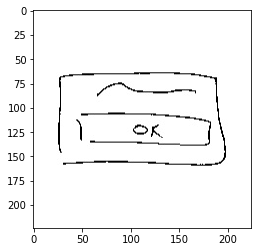

In [4]:
plt.imshow(cv2.imread('data/%s'%str(data['name'][2]))) # Paper

Podemos examinar a profundidad las variables nominales de este conjunto de datos:

In [5]:
columnas = data.columns
for c in columnas[1:4]:
    print(f'{c} \t: {len(pd.unique(data[c]))} valores únicos')

label 	: 21 valores únicos
medium 	: 2 valores únicos
device 	: 6 valores únicos


Podemos comparar las variables *medium* y *device* para analizar si existe alguna relación entre estas.

medium  digital  paper
device                
finger       65      0
mouse       131      0
pen           0   4015
pencil        0   1490
stylus    13276      0


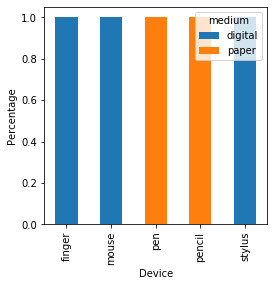

In [6]:
print(pd.crosstab(data["device"],data["medium"]))
Medium = pd.crosstab(data["device"],data["medium"])
Medium.div(Medium.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("Device")
plt.ylabel("Percentage")
plt.show()

La variable *medium* y *paper* están claramente relacionadas.
Aquellos bosquejos realizados en papel fueron hechos con las herramientas esperadas: lápiz o lapicero. Por otro lado, el medio digital permite que los diseñadores usen otros dispositivos, como su dedo, mouse, o *stylus* (similar a un lápiz, para dibujos digitales).

Además, notamos que se identificaron únicamente 5 valores únicos en *device*, por lo que el sexto valor señalado por la función $unique()$ podría ser el resultado de valores nulos. Para eso, vemos un resumen de los datos:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19000 entries, 0 to 18999
Data columns (total 4 columns):
name      19000 non-null object
label     19000 non-null object
medium    19000 non-null object
device    18977 non-null object
dtypes: object(4)
memory usage: 593.8+ KB


La columna *device* tiene 23 datos vacíos. Por lo tanto, si deseamos usarla, necesitamos llenar esos datos.

Entonces, elegimos como variable objetivo *medium*, sin datos faltantes, en lugar de *device*, donde sería redundante la información sobre el medio (digital o papel). Evaluamos la distribución de esta variable nominal:

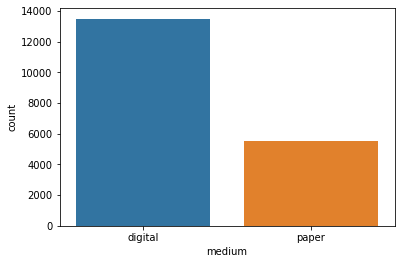

In [132]:
import seaborn as sns

sns.countplot(data['medium'])

El conjunto de datos está desbalanceado, pues hay muchos más ejemplos de bosquejos hechos digitalmente que a mano.

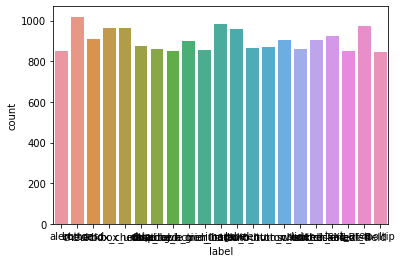

In [133]:
sns.countplot(data['label'])

In [136]:
data['label'].value_counts()

button                    1019
image                      983
text_field                 975
checkbox_unchecked         963
checkbox_checked           962
label                      957
switch_enabled             927
card                       908
radio_button_unchecked     907
switch_disabled            905
floating_action_button     898
chip                       877
radio_button_checked       868
menu                       866
data_table                 863
slider                     863
grid_list                  857
text_area                  853
dropdown_menu              852
alert                      850
tooltip                    847
Name: label, dtype: int64

### 3.2. Preprocesamiento

### 3.2.1. Under Sampling

In [9]:
import random

In [10]:
n = len(data[data['medium'] == 'digital']) - len(data[data['medium'] == 'paper'])
print(f'Diferencia entre Digital y Paper: {n}')

Diferencia entre Digital y Paper: 7990


In [11]:
digital_index = [i for i in data[data['medium'] == 'digital'].index]
print('Filas con imágenes digitales:', digital_index[:5])

Filas con imágenes digitales: [0, 1, 3, 5, 6]


De entre todas las instancias con bosquejos digitales, marcamos aleatoriamente 7990 para su eliminación, y así tener un conjunto de datos balanceado.

In [12]:
random_drop = random.sample(digital_index, n)
print(f'Se van a eliminar {len(random_drop)} filas')
random_drop[:5]

Se van a eliminar 7990 filas


[797, 6016, 8116, 13645, 17350]

In [13]:
data = data.drop(random_drop)

In [14]:
len(data)

11010

Adicionalmente, dado que solamente usaremos la columna de entrada (*image*) y la etiqueta *medium*, también soltamos las demás columnas.

In [15]:
data = data.drop(columns=['label', 'device'])
print(data.columns)

Index(['name', 'medium'], dtype='object')


Guardamos el DataFrame resultante:

In [16]:
data.to_csv('data/data_under.csv',index=False)

Validamos que funcione:

In [2]:
data = pd.read_csv('data/data_under.csv')
print(len(data))
print(data.columns)

11010
Index(['name', 'medium'], dtype='object')


In [4]:
imgs = []
for r in data['name']:
    img = cv2.imread('data/%s'%str(r))
    imgs.append(img)
data["image"] = imgs

### 3.2.2. Reshaping

In [5]:
data['image'].values.shape

(11010,)

Los datos de entrada serán las imágenes:

In [6]:
X = np.array(data.iloc[:,-1].values) #.to_numpy()
y = np.array(data.iloc[:,1].values) #.to_numpy()
print(X.shape)
print(y.shape)
print(y[:5])

(11010,)
(11010,)
['digital' 'paper' 'digital' 'paper' 'paper']


In [7]:
lut = {'digital': 0, 'paper': 1}
for i in range(len(y)):
    y[i] = lut[y[i]]
y[:5]

array([0, 1, 0, 1, 1], dtype=object)

Para su ingreso en ResNet, necesitamos asegurar que $X$ sea considerado un arreglo de 4 dimensiones:

In [8]:
#X = np.array([np.array(x, dtype=np.uint8) for x in X], dtype=np.uint8)
X = np.array([x for x in X], dtype=np.uint8)
X.shape

(11010, 224, 224, 3)

In [9]:
y = np.array(y.reshape((y.shape[0],1)), dtype=np.uint8)
y.shape

(11010, 1)

### 3.2.3. Dividir en Training y Test

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(f'Entrenamiento: {len(X_train)} imágenes, cada una de {X_train[0].shape} dimensiones')

Entrenamiento: 8808 imágenes, cada una de (224, 224, 3) dimensiones


In [77]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
# load (downloaded if needed) the MNIST dataset
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

In [78]:
X_train_mnist.shape

(60000, 28, 28)

In [80]:
from PIL import Image

def norm_image(img):
    new_img = np.array(img)
    new_img.resize((32,32))
    return new_img

In [82]:
norm_image(X_train_mnist[0]).shape

(32, 32)

In [83]:
X_train_mnist = [norm_image(x) for x in X_train_mnist]

In [84]:
X_train_mnist = np.array(X_train_mnist)
X_train_mnist.shape

(60000, 32, 32)

In [85]:
X_train_mnist.shape = (60000,32,32,1)

In [97]:
y_train_mnist.shape = (60000,1)

### 3.3. ResNet

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [110]:
input_shape = X_train.shape[1:]
inputs = keras.Input(shape=input_shape)
classes = 2

print(f'Input Shape: {input_shape}')
print(f'Inputs (Keras): {inputs}')
print(f'Clases posibles: {classes}')

Input Shape: (224, 224, 3)
Inputs (Keras): KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_11'), name='input_11', description="created by layer 'input_11'")
Clases posibles: 2


In [109]:
input_shape = X_train_mnist.shape[1:]
inputs = keras.Input(shape=input_shape)
classes = 2

print(f'Input Shape: {input_shape}')
print(f'Inputs (Keras): {inputs}')
print(f'Clases posibles: {classes}')

Input Shape: (32, 32, 1)
Inputs (Keras): KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")
Clases posibles: 2


In [111]:
x = layers.Rescaling(1.0 / 255)(inputs)

In [112]:
outputs = keras.applications.ResNet50(  # Add the rest of the model
    weights=None, input_shape=input_shape, classes=classes
)(x)

In [113]:
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [114]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [115]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [116]:
train_dataset = train_dataset.batch(16).map(lambda x, y: (data_augmentation(x), y))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [117]:
# Para que puedan correr así 
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [118]:
model.fit(train_dataset, steps_per_epoch=5, epochs=10)

Epoch 1/10
5/5 [==============================] - 88s 18s/step - loss: 5.1398
Epoch 2/10
5/5 [==============================] - 106s 21s/step - loss: 1.4686
Epoch 3/10
5/5 [==============================] - 104s 21s/step - loss: 1.2679
Epoch 4/10
5/5 [==============================] - 110s 22s/step - loss: 1.6235
Epoch 5/10
5/5 [==============================] - 104s 20s/step - loss: 0.7125
Epoch 6/10
5/5 [==============================] - 100s 20s/step - loss: 1.1632
Epoch 7/10
5/5 [==============================] - 105s 21s/step - loss: 0.9352
Epoch 8/10
5/5 [==============================] - 113s 23s/step - loss: 0.8405
Epoch 9/10
5/5 [==============================] - 99s 20s/step - loss: 1.1723
Epoch 10/10
5/5 [==============================] - 98s 20s/step - loss: 0.8629


### 3.1. Resultados del modelo

Realizamos una predicción del conjunto de datos de prueba:

In [119]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [120]:
y_pred = model.predict(X_test)

In [121]:
def which_one(pred):
    "Retorna puntualmente cuál tiene la mayor probabilidad"
    res = []
    for i, v in enumerate(pred):
        res.append([i,v])
    res.sort(key=lambda x: x[1], reverse=True)
    #print(res)
    return res[0][0]

y_pred_flat = [which_one(i) for i in y_pred]

In [122]:
y_test_flat = y_test.reshape((2202,))
y_test_flat

array([1, 1, 0, ..., 1, 1, 0], dtype=uint8)

Podemos ver el resultado para las primeras 10 instancias:

In [123]:
for i in range(10):
    print(f'Pred: {which_one(y_pred[i])} Test: {y_test_flat[i]}')

Pred: 1 Test: 1
Pred: 1 Test: 1
Pred: 1 Test: 0
Pred: 1 Test: 0
Pred: 1 Test: 1
Pred: 1 Test: 0
Pred: 1 Test: 0
Pred: 1 Test: 0
Pred: 1 Test: 0
Pred: 1 Test: 0


In [124]:
cm = confusion_matrix(y_test_flat, y_pred_flat)

In [125]:
pd.DataFrame(cm, 
             columns = ['digital', 'paper'])

,digital,paper
0,0,1092
1,0,1110


In [126]:
print(classification_report(y_test_flat, y_pred_flat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1092
           1       0.50      1.00      0.67      1110

    accuracy                           0.50      2202
   macro avg       0.25      0.50      0.34      2202
weighted avg       0.25      0.50      0.34      2202



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_flat, y_pred[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'Este modelo presenta un AUC de {roc_auc}')

Este modelo presenta un AUC de 0.4631855756855757


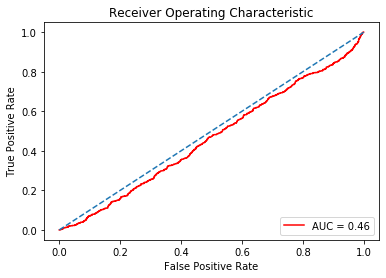

In [128]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4. Conclusiones

## 5. Recomendaciones

## Referencias bibliográficas:

1. Brownlee, J. (16 de agosto de 2019). What is Deep Learning?. *Machine Learning Mastery* Recuperado de: https://machinelearningmastery.com/what-is-deep-learning/ 
2. Mandal, M. (1 de mayo de 2021). Introduction to Convolutional Neural Networks (CNN). *Analytics Vidha*. Recuperado de: https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/
3. He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Deep Residual Learning for Image Recognition* Recuperado de: https://arxiv.org/abs/1512.03385
4. Feng, V. (15 de julio de 2020). An Overview of ResNet and its Variants. *Towards Data Science*. Recuperado de: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035
5. Mutjaba, H. (28 de septiembre de 2020). Introduction to Resnet or Residual Network. *Great Learning*. Recuperado de: https://www.mygreatlearning.com/blog/resnet/ 
6. Boesch, G. (29 de agosto de 2021). Deep Residual Networks (ResNet, ResNet50) – Guide in 2021 *Viso.ai*. Recuperado de: https://viso.ai/deep-learning/resnet-residual-neural-network/
7. TensorFlow (12 de Noviembre de 2021) *Trabajar con capas de preprocesamiento* Recuperado de: https://www.tensorflow.org/guide/keras/preprocessing_layers
8. Pandian, V. (2021). UISketch Dataset *Kaggle* Recuperado de: https://www.kaggle.com/vinothpandian/uisketch 